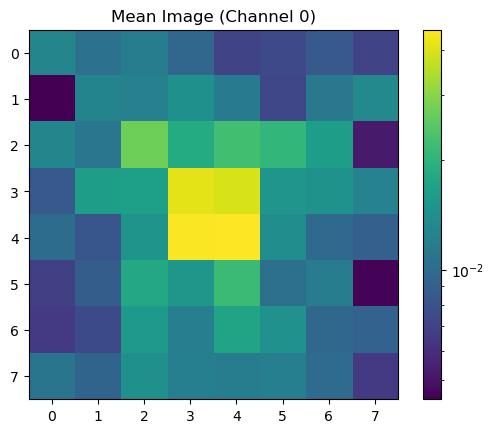

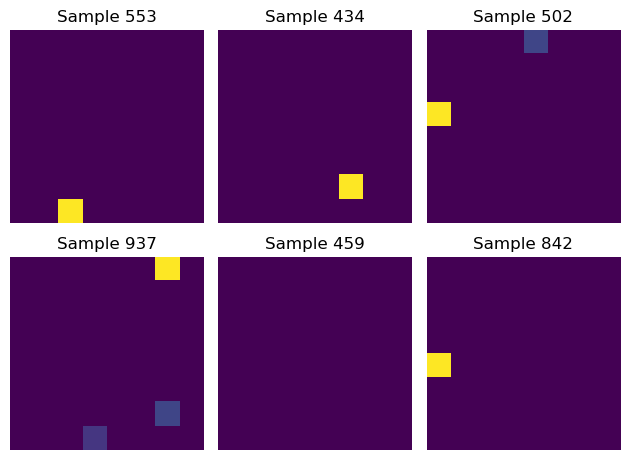

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2
from itertools import product
import matplotlib

size = 8
Nvals = 20
Nsamples = 1000
channel = 2
crop_fraction = 0.7
file_name = "QG_discretized_N4_M8_channel0.hdf5"

with h5py.File("C:\\Users\\riakh\\Downloads\\quark-gluon_train-set_n793900-001.hdf5", "r") as f:
    X_jets = f["X_jets"][:Nsamples]
    y = f["y"][:Nsamples]


def discretize_img(img, Nvals):
    bins = np.linspace(0, 1, Nvals + 1)
    vals = np.linspace(0, 1, Nvals)
    inds = np.digitize(img, bins)
    return vals[inds - 1]

def crop_and_resize_opencv(x, channel, crop_fraction, scale):
    cropped_imgs = []
    for i in range(x.shape[0]):
        img = x[i, :, :, channel]
        h, w = img.shape
        crop_size = int(h * crop_fraction)
        start = (h - crop_size) // 2
        cropped = img[start:start+crop_size, start:start+crop_size]
        resized = cv2.resize(cropped, (scale, scale), interpolation=cv2.INTER_LINEAR)
        cropped_imgs.append(resized)
    return np.array(cropped_imgs)


resized_images = crop_and_resize_opencv(X_jets, channel, crop_fraction, size)
div1 = np.max(resized_images, axis=(1, 2), keepdims=True)
div1[div1 == 0] = 1
normalized = resized_images / (div1 + 1e-5)
discretized = discretize_img(normalized, Nvals)

with h5py.File(file_name, "w") as fnew:
    fnew.create_dataset("X", data=discretized.astype('float32'))
    fnew.create_dataset("y", data=y.astype('int'))

with h5py.File(file_name, "r") as f:
    avg_img = np.mean(f["X"], axis=0)
    plt.imshow(avg_img, norm=matplotlib.colors.LogNorm())
    plt.title("Mean Image (Channel 0)")
    plt.colorbar()
    plt.show()

    fig, ax = plt.subplots(2, 3)
    for i, j in product(range(2), range(3)):
        idx = np.random.randint(0, f["X"].shape[0])
        ax[i, j].imshow(f["X"][idx])
        ax[i, j].set_title(f"Sample {idx}")
        ax[i, j].axis("off")
    plt.tight_layout()
    plt.show()


In [3]:
pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.5 MB 871.5 kB/s eta 0:00:46
   ---------------------------------------- 0.1/39.5 MB 1.6 MB/s eta 0:00:25
   ---------------------------------------- 0.2/39.5 MB 1.8 MB/s eta 0:00:22
   ---------------------------------------- 0.4/39.5 MB 2.3 MB/s eta 0:00:18
    --------------------------------------- 0.5/39.5 MB 2.2 MB/s eta 0:00:18
    --------------------------------------- 0.7/39.5 MB 2.3 MB/s eta 0:00:17
    --------------------------------------- 0.8/39.5 MB 2.5 MB/s eta 0:00:16
   - -------------------------------------- 1.0/39.5 MB 2.6 MB/s eta 0:00:15
   - -------------------------------------- 1.2/39.5 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.4/39.5 MB 2.9 MB/s eta 0:00:14
   - -------------------------------------- 1.5/39.5 MB 2.9 MB/s eta 0:00:13
 

In [38]:
print(torch.bincount(y_tensor))

tensor([2487, 2513])


In [48]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
def load_dataset():
    with h5py.File("C:\\Users\\riakh\\Downloads\\quark-gluon_train-set_n793900-001.hdf5", "r") as f:
        n = 20000
        keys = list(f.keys())
        for i in keys:
            print(i, f[i].shape)
        data = {
            "X_jets": f["X_jets"][:n],
            "y": f["y"][:n]
        }
    return data

data = load_dataset()

# Split quarks (label 1) and gluons (label 0)
labels = data["y"]
X_jets = data["X_jets"]

data0 = X_jets[labels == 0]  # Gluon jets
data1 = X_jets[labels == 1]  # Quark jets

print(f"Gluons: {data0.shape}, Quarks: {data1.shape}")


X_jets (793900, 125, 125, 3)
m0 (793900,)
pt (793900,)
y (793900,)
Gluons: (10010, 125, 125, 3), Quarks: (9990, 125, 125, 3)


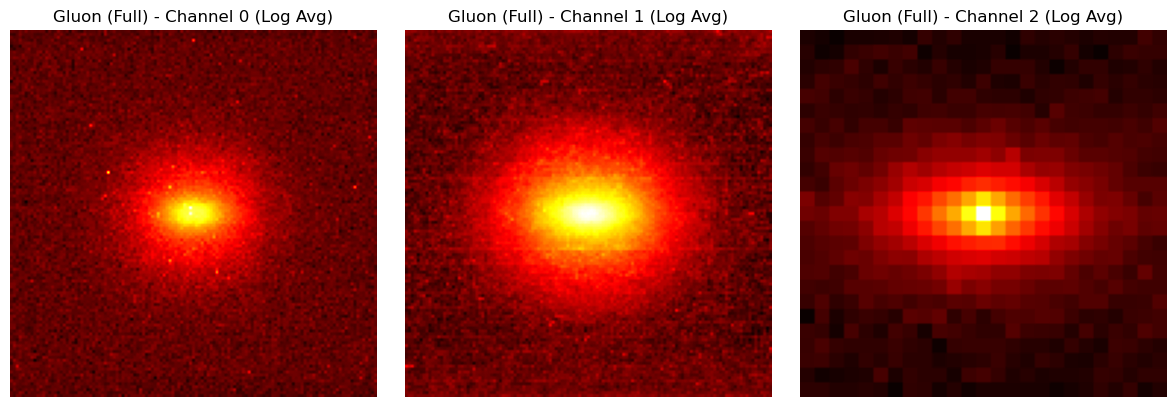

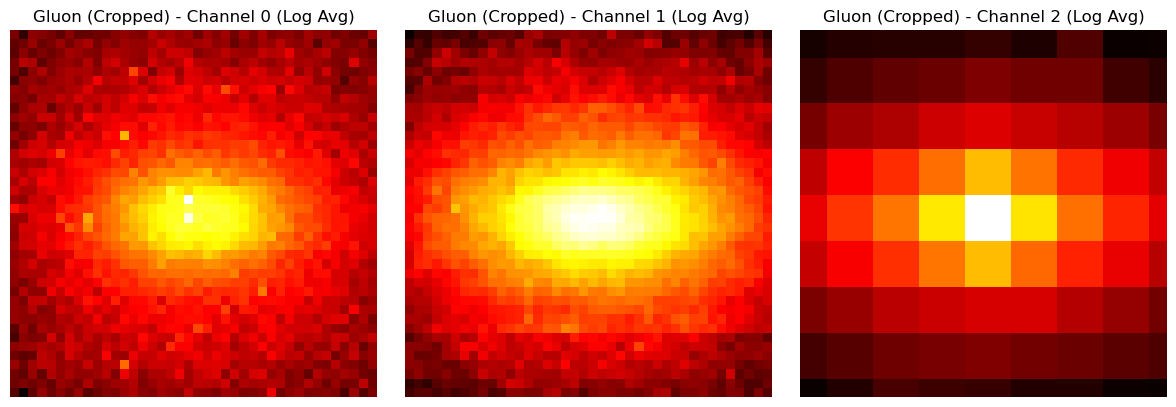

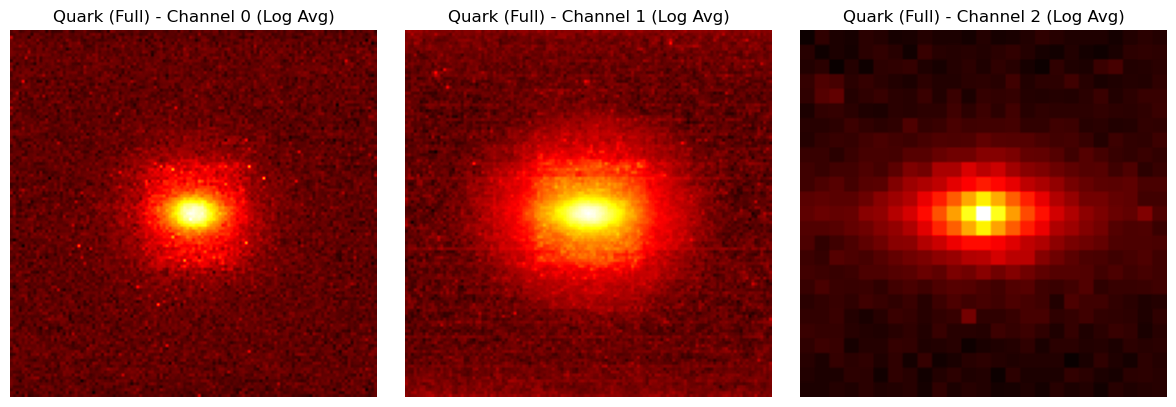

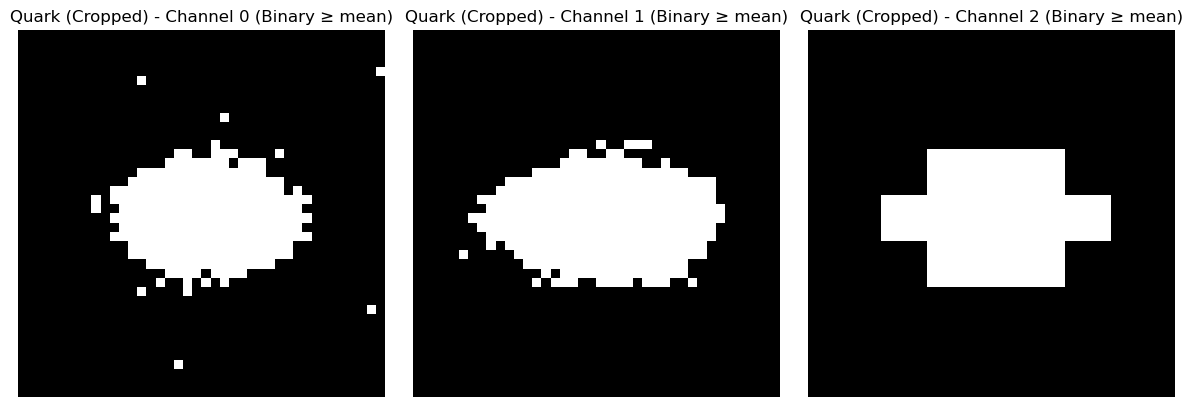

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def crop_center(img, cropx, cropy):
    x, y = img.shape[1:3]
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[:, startx:startx + cropx, starty:starty + cropy, :]

def display_data(data, label, thresh=0):
    fig = plt.figure(figsize=(12, 4))
    r, c = 1, 3
    for i in range(3):
        fig.add_subplot(r, c, i + 1)
        avg_img = np.mean(data[:, :, :, i], axis=0)
        if thresh:
            m = avg_img.mean()
            plt.imshow(avg_img >= m, cmap="gray")
            plt.title(f"{label} - Channel {i} (Binary ≥ mean)")
        else:
            plt.imshow(np.log(avg_img + 1e-6), cmap="hot")
            plt.title(f"{label} - Channel {i} (Log Avg)")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


data0_cropped = crop_center(data0, 40, 40)
data1_cropped = crop_center(data1, 40, 40)

display_data(data0, "Gluon (Full)")
display_data(data0_cropped, "Gluon (Cropped)", thresh=0)

display_data(data1, "Quark (Full)")
display_data(data1_cropped, "Quark (Cropped)", thresh=1)


In [63]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
from typing import *

crop_size = 40
Nsamples = 1000
file_path = "C:\\Users\\riakh\\Downloads\\quark-gluon_train-set_n793900-001.hdf5"

def load_and_preprocess(file_path, Nsamples=5000, crop_size=40):
    with h5py.File(file_path, "r") as f:
        X_jets = f["X_jets"][:Nsamples]  # [N, 125, 125, 3]
        y = f["y"][:Nsamples]            # [N,]

    def crop_center(img, cropx, cropy):
        x, y = img.shape[1:3]
        startx = x // 2 - (cropx // 2)
        starty = y // 2 - (cropy // 2)
        return img[:, startx:startx + cropx, starty:starty + cropy, :]

    cropped = crop_center(X_jets, crop_size, crop_size)
    
    ch0 = cropped[:, :, :, 1]
    ch1 = cropped[:, :, :, 2]

    def normalize_channel(ch):
        div = np.max(ch, axis=(1, 2), keepdims=True)
        div[div == 0] = 1
        return ch / (div + 1e-5)

    ch0 = normalize_channel(ch0)
    ch1 = normalize_channel(ch1)

    combined = np.concatenate([ch0, ch1], axis=-1)  # [N, 40, 40, 2]
    X_tensor = torch.tensor(combined.reshape(Nsamples, -1), dtype=torch.float32)  # [N, 3200]
    y_tensor = torch.tensor(y, dtype=torch.long)

    return train_test_split(X_tensor, y_tensor, test_size=0.2, stratify=y, random_state=42)

X_train, X_test, y_train, y_test = load_and_preprocess(file_path, Nsamples, crop_size)

def forward_step(i_n, grid_size, A, K, C):
    ratio = A * grid_size**(-K) + C
    return ratio * i_n

class SineKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, device='cpu', grid_size=5, is_first=False, add_bias=True, norm_freq=True):
        super(SineKANLayer, self).__init__()
        self.grid_size = grid_size
        self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_first = is_first
        self.add_bias = add_bias

        self.A, self.K, self.C = 0.9724, 0.9884, 0.9994

        self.grid_norm_factor = (torch.arange(grid_size) + 1).reshape(1, 1, grid_size)
        if is_first:
            self.amplitudes = nn.Parameter(
                torch.empty(output_dim, input_dim, 1).normal_(0, .4) / output_dim / self.grid_norm_factor
            )
        else:
            self.amplitudes = nn.Parameter(
                torch.empty(output_dim, input_dim, 1).uniform_(-1, 1) / output_dim / self.grid_norm_factor
            )

        grid_phase = torch.arange(1, grid_size + 1).reshape(1, 1, 1, grid_size) / (grid_size + 1)
        self.input_phase = torch.linspace(0, math.pi, input_dim).reshape(1, 1, input_dim, 1).to(device)
        phase = grid_phase.to(device) + self.input_phase

        if norm_freq:
            self.freq = nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size) / (grid_size + 1)**(1 - is_first))
        else:
            self.freq = nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size))

        for i in range(1, self.grid_size):
            phase = forward_step(phase, i, self.A, self.K, self.C)

        self.register_buffer('phase', phase)

        if self.add_bias:
            self.bias = nn.Parameter(torch.ones(1, output_dim) / output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x_reshaped = x.view(x.shape[0], 1, x.shape[1], 1)
        s = torch.sin(x_reshaped * self.freq + self.phase)
        y = torch.einsum('ijkl,jkl->ij', s, self.amplitudes)
        if self.add_bias:
            y += self.bias
        return y


class SineKAN(nn.Module):
    def __init__(self, layers_hidden: List[int], grid_size=8, device='cpu'):
        super(SineKAN, self).__init__()
        self.layers = nn.ModuleList([
            SineKANLayer(in_dim, out_dim, device, grid_size=grid_size, is_first=(i==0))
            for i, (in_dim, out_dim) in enumerate(zip(layers_hidden[:-1], layers_hidden[1:]))
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def train_sinekan_model(X_train, X_test, y_train, y_test, input_dim=3200, output_dim=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SineKAN([input_dim, 128, output_dim], grid_size=8, device=device).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    epochs = 100
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train.to(device))
        loss = criterion(out, y_train.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            model.eval()
            test_preds = model(X_test.to(device)).argmax(dim=1)
            acc = (test_preds == y_test.to(device)).float().mean().item()

        print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

train_sinekan_model(X_train, X_test, y_train, y_test, input_dim=40*40*2)


Epoch 001 | Loss: 0.7107 | Test Acc: 0.5050
Epoch 002 | Loss: 11.0581 | Test Acc: 0.4950
Epoch 003 | Loss: 8.6128 | Test Acc: 0.4950
Epoch 004 | Loss: 4.2524 | Test Acc: 0.4950
Epoch 005 | Loss: 3.4729 | Test Acc: 0.5050
Epoch 006 | Loss: 0.7880 | Test Acc: 0.5050
Epoch 007 | Loss: 3.2880 | Test Acc: 0.5050
Epoch 008 | Loss: 1.4745 | Test Acc: 0.4950
Epoch 009 | Loss: 0.7982 | Test Acc: 0.4950
Epoch 010 | Loss: 0.7414 | Test Acc: 0.4950
Epoch 011 | Loss: 0.6899 | Test Acc: 0.5050
Epoch 012 | Loss: 0.8919 | Test Acc: 0.4950
Epoch 013 | Loss: 1.8804 | Test Acc: 0.4950
Epoch 014 | Loss: 0.6873 | Test Acc: 0.5050
Epoch 015 | Loss: 0.7196 | Test Acc: 0.4950
Epoch 016 | Loss: 1.4713 | Test Acc: 0.5050
Epoch 017 | Loss: 0.7354 | Test Acc: 0.5050
Epoch 018 | Loss: 0.8550 | Test Acc: 0.4950
Epoch 019 | Loss: 0.8846 | Test Acc: 0.4950
Epoch 020 | Loss: 0.7900 | Test Acc: 0.5050
Epoch 021 | Loss: 0.7677 | Test Acc: 0.5050
Epoch 022 | Loss: 0.8017 | Test Acc: 0.4800
Epoch 023 | Loss: 0.6934 | Test

In [5]:
pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: C:\Users\riakh\AppData\Local\anaconda3\envs\gan\python.exe -m pip install --upgrade pip


In [3]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

def load_and_preprocess(file_path, Nsamples=1000):
    with h5py.File(file_path, "r") as f:
        X = f["X_jets"][:Nsamples] 
        y = f["y"][:Nsamples]

    def center_crop(imgs, size):
        h, w = imgs.shape[1:3]
        ch, cw = size
        sh, sw = h // 2 - ch // 2, w // 2 - cw // 2
        return imgs[:, sh:sh + ch, sw:sw + cw, :]

    cropped = center_crop(X, (10, 10))
    ch0 = cropped[..., 1]
    ch1 = cropped[..., 2]

    def normalize(ch):
        div = ch.max(axis=(1, 2), keepdims=True)
        div[div == 0] = 1
        return ch / div

    X_norm = torch.tensor(
        torch.stack([torch.tensor(normalize(ch0)), torch.tensor(normalize(ch1))], dim=1),
        dtype=torch.float32
    )  # [N, 2, 8, 8]
    y_tensor = torch.tensor(y, dtype=torch.long)

    return train_test_split(X_norm, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42)

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                      
            nn.Linear(288, 144),
            nn.ReLU(),
            nn.Linear(144, 72),
            nn.ReLU(),
            nn.Linear(72, 36),
            nn.ReLU(),
            nn.Linear(36, 2)                  
        )

    def forward(self, x):
        return self.net(x)

def train_mlp(path):
    X_train, X_test, y_train, y_test = load_and_preprocess(path, Nsamples=1000)
    model = SimpleMLP()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, 51):
        model.train()
        optimizer.zero_grad()
        out = model(X_train.to(device))
        loss = criterion(out, y_train.to(device))
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = model(X_test.to(device)).argmax(dim=1)
            acc = (preds == y_test.to(device)).float().mean().item()

        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

train_mlp("C:\\Users\\riakh\\Downloads\\quark-gluon_train-set_n793900-001.hdf5")


C:\Users\riakh\AppData\Local\Temp\ipykernel_23492\1380804494.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_norm = torch.tensor(


Epoch 001 | Loss: 0.6937 | Test Acc: 0.5050
Epoch 002 | Loss: 0.6928 | Test Acc: 0.5300
Epoch 003 | Loss: 0.6920 | Test Acc: 0.4900
Epoch 004 | Loss: 0.6914 | Test Acc: 0.5000
Epoch 005 | Loss: 0.6906 | Test Acc: 0.5050
Epoch 006 | Loss: 0.6898 | Test Acc: 0.4900
Epoch 007 | Loss: 0.6888 | Test Acc: 0.4800
Epoch 008 | Loss: 0.6877 | Test Acc: 0.4700
Epoch 009 | Loss: 0.6866 | Test Acc: 0.4450
Epoch 010 | Loss: 0.6854 | Test Acc: 0.4400
Epoch 011 | Loss: 0.6841 | Test Acc: 0.4400
Epoch 012 | Loss: 0.6826 | Test Acc: 0.4450
Epoch 013 | Loss: 0.6810 | Test Acc: 0.4600
Epoch 014 | Loss: 0.6792 | Test Acc: 0.4650
Epoch 015 | Loss: 0.6772 | Test Acc: 0.4650
Epoch 016 | Loss: 0.6751 | Test Acc: 0.4700
Epoch 017 | Loss: 0.6726 | Test Acc: 0.4750
Epoch 018 | Loss: 0.6699 | Test Acc: 0.4650
Epoch 019 | Loss: 0.6667 | Test Acc: 0.4700
Epoch 020 | Loss: 0.6632 | Test Acc: 0.4900
Epoch 021 | Loss: 0.6593 | Test Acc: 0.5050
Epoch 022 | Loss: 0.6552 | Test Acc: 0.5100
Epoch 023 | Loss: 0.6508 | Test 

In [5]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
from typing import *


SEED = 10
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- Parameters ---
crop_size = 12
Nsamples = 1000
file_path = "C:\\Users\\riakh\\Downloads\\quark-gluon_train-set_n793900-001.hdf5"

def load_and_preprocess(file_path, Nsamples=1000, crop_size=12):
    with h5py.File(file_path, "r") as f:
        X_jets = f["X_jets"][:Nsamples] 
        y = f["y"][:Nsamples]     

    def crop_center(img, cropx, cropy):
        x, y = img.shape[1:3]
        startx = x // 2 - (cropx // 2)
        starty = y // 2 - (cropy // 2)
        return img[:, startx:startx + cropx, starty:starty + cropy, :]

    cropped = crop_center(X_jets, crop_size, crop_size)
    
    ch0 = cropped[:, :, :, 1]
    ch1 = cropped[:, :, :, 2]
    def normalize_channel(ch):
        div = np.max(ch, axis=(1, 2), keepdims=True)
        div[div == 0] = 1
        return ch / (div + 1e-5)

    ch0 = normalize_channel(ch0)
    ch1 = normalize_channel(ch1)

    combined = np.concatenate([ch0, ch1], axis=-1)  # [N, 40, 40, 2]
    X_tensor = torch.tensor(combined.reshape(Nsamples, -1), dtype=torch.float32)  # [N, 3200]
    y_tensor = torch.tensor(y, dtype=torch.long)

    return train_test_split(X_tensor, y_tensor, test_size=0.2, stratify=y, random_state=42)

X_train, X_test, y_train, y_test = load_and_preprocess(file_path, Nsamples, crop_size)

def forward_step(i_n, grid_size, A, K, C):
    ratio = A * grid_size**(-K) + C
    return ratio * i_n

class SineKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, device='cpu', grid_size=5, is_first=False, add_bias=True, norm_freq=True):
        super(SineKANLayer, self).__init__()
        self.grid_size = grid_size
        self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_first = is_first
        self.add_bias = add_bias

        self.A, self.K, self.C = 0.9724, 0.9884, 0.9994

        self.grid_norm_factor = (torch.arange(grid_size) + 1).reshape(1, 1, grid_size)
        if is_first:
            self.amplitudes = nn.Parameter(
                torch.empty(output_dim, input_dim, 1).normal_(0, .4) / output_dim / self.grid_norm_factor
            )
        else:
            self.amplitudes = nn.Parameter(
                torch.empty(output_dim, input_dim, 1).uniform_(-1, 1) / output_dim / self.grid_norm_factor
            )

        grid_phase = torch.arange(1, grid_size + 1).reshape(1, 1, 1, grid_size) / (grid_size + 1)
        self.input_phase = torch.linspace(0, math.pi, input_dim).reshape(1, 1, input_dim, 1).to(device)
        phase = grid_phase.to(device) + self.input_phase

        if norm_freq:
            self.freq = nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size) / (grid_size + 1)**(1 - is_first))
        else:
            self.freq = nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size))

        for i in range(1, self.grid_size):
            phase = forward_step(phase, i, self.A, self.K, self.C)

        self.register_buffer('phase', phase)

        if self.add_bias:
            self.bias = nn.Parameter(torch.ones(1, output_dim) / output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x_reshaped = x.view(x.shape[0], 1, x.shape[1], 1)
        s = torch.sin(x_reshaped * self.freq + self.phase)
        y = torch.einsum('ijkl,jkl->ij', s, self.amplitudes)
        if self.add_bias:
            y += self.bias
        return y

class SineKAN(nn.Module):
    def __init__(self, layers_hidden: List[int], grid_size=8, device='cpu'):
        super(SineKAN, self).__init__()
        self.layers = nn.ModuleList([
            SineKANLayer(in_dim, out_dim, device, grid_size=grid_size, is_first=(i==0))
            for i, (in_dim, out_dim) in enumerate(zip(layers_hidden[:-1], layers_hidden[1:]))
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def train_sinekan_model(X_train, X_test, y_train, y_test, input_dim=288, output_dim=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SineKAN([input_dim, 144, output_dim], grid_size=8, device=device).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    epochs = 300
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train.to(device))
        loss = criterion(out, y_train.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            model.eval()
            test_preds = model(X_test.to(device)).argmax(dim=1)
            acc = (test_preds == y_test.to(device)).float().mean().item()

        print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

train_sinekan_model(X_train, X_test, y_train, y_test, input_dim=12*12*2)


Epoch 001 | Loss: 3.7741 | Test Acc: 0.5050
Epoch 002 | Loss: 11.4468 | Test Acc: 0.5050
Epoch 003 | Loss: 16.5859 | Test Acc: 0.5050
Epoch 004 | Loss: 7.9846 | Test Acc: 0.5050
Epoch 005 | Loss: 3.8777 | Test Acc: 0.4950
Epoch 006 | Loss: 0.8979 | Test Acc: 0.4950
Epoch 007 | Loss: 8.0428 | Test Acc: 0.4950
Epoch 008 | Loss: 1.4979 | Test Acc: 0.5150
Epoch 009 | Loss: 0.9109 | Test Acc: 0.5750
Epoch 010 | Loss: 1.1316 | Test Acc: 0.5250
Epoch 011 | Loss: 2.0232 | Test Acc: 0.4950
Epoch 012 | Loss: 1.4163 | Test Acc: 0.5050
Epoch 013 | Loss: 1.7064 | Test Acc: 0.5900
Epoch 014 | Loss: 0.7240 | Test Acc: 0.4950
Epoch 015 | Loss: 0.9566 | Test Acc: 0.5450
Epoch 016 | Loss: 0.9349 | Test Acc: 0.5750
Epoch 017 | Loss: 0.7107 | Test Acc: 0.4950
Epoch 018 | Loss: 0.9427 | Test Acc: 0.5200
Epoch 019 | Loss: 0.7092 | Test Acc: 0.5050
Epoch 020 | Loss: 0.8709 | Test Acc: 0.4550
Epoch 021 | Loss: 0.7097 | Test Acc: 0.4950
Epoch 022 | Loss: 0.8032 | Test Acc: 0.5650
Epoch 023 | Loss: 0.6876 | Tes

In [1]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from sklearn.model_selection import train_test_split
import math

SEED = 10
torch.manual_seed(SEED)
np.random.seed(SEED)

def load_and_preprocess(file_path, Nsamples=1000, crop_size=16):
    with h5py.File(file_path, "r") as f:
        X_jets = f["X_jets"][:Nsamples]
        y = f["y"][:Nsamples]

    def crop_center(img, cx, cy):
        x, y = img.shape[1:3]
        sx, sy = x // 2 - cx // 2, y // 2 - cy // 2
        return img[:, sx:sx + cx, sy:sy + cy, :]

    cropped = crop_center(X_jets, crop_size, crop_size)
    ch0 = cropped[..., 1]
    ch1 = cropped[..., 2]

    def normalize(ch):
        div = np.max(ch, axis=(1, 2), keepdims=True)
        div[div == 0] = 1
        return ch / (div + 1e-5)

    X = np.concatenate([normalize(ch0), normalize(ch1)], axis=-1)
    return train_test_split(
        torch.tensor(X.reshape(Nsamples, -1), dtype=torch.float32),
        torch.tensor(y, dtype=torch.long),
        test_size=0.2, stratify=y, random_state=42
    )

class QSVTBlock(nn.Module):
    def __init__(self, cheb_coeffs_list, chunk_size=8):
        super().__init__()
        self.chunk_size = chunk_size
        self.cheb_coeffs_list = [torch.tensor(c, dtype=torch.float32) for c in cheb_coeffs_list]
        self.theta = nn.Parameter(torch.randn(1))
        self.dev = qml.device("default.qubit", wires=1)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def qsvt_circuit(x_scalar, coeffs, theta):
            x_scalar = torch.clamp(x_scalar, -1.0, 1.0)
            qml.RY(x_scalar, wires=0)
            A = torch.tensor([[x_scalar]])
            qml.qsvt(A, coeffs, encoding_wires=[0], block_encoding="embedding")
            qml.RZ(theta[0], wires=0)
            return qml.expval(qml.PauliZ(0))

        self.qsvt_circuit = qsvt_circuit

    def forward(self, x):
        B, D = x.shape
        out = []
        for i in range(0, D, self.chunk_size):
            chunk = x[:, i:i+self.chunk_size]
            coeffs = self.cheb_coeffs_list[i % len(self.cheb_coeffs_list)]
            qout = [self.qsvt_circuit(val, coeffs, self.theta) for val in chunk.flatten()]
            qout = torch.stack(qout).view(B, -1)
            out.append(qout)
        return torch.cat(out, dim=1)

class QuantumLCULayer(nn.Module):
    def __init__(self, num_features, chunk_size=4):
        super().__init__()
        self.chunk_size = chunk_size
        self.weights = nn.Parameter(torch.randn(num_features // chunk_size, chunk_size))
        self.dev = qml.device("default.qubit", wires=3)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def lcu_circuit(vals, wts):
            qml.RY(vals[0], wires=0)
            qml.RY(wts[0], wires=1)
            qml.CNOT(wires=[0, 2])
            angle = torch.clamp(vals[0] * wts[0], -math.pi, math.pi)
            qml.ctrl(qml.RZ, control=0)(angle, wires=2)
            return qml.expval(qml.PauliZ(2))

        self.lcu_circuit = lcu_circuit

    def forward(self, x):
        B, D = x.shape
        x = x.view(B, D // self.chunk_size, self.chunk_size)
        out = []
        for b in range(B):
            row = []
            for i in range(x.shape[1]):
                vals = x[b, i]
                wts = self.weights[i]
                row.append(self.lcu_circuit(vals.clone(), wts.clone()))
            out.append(torch.stack(row))
        return torch.stack(out)

def forward_step(i_n, grid_size, A, K, C):
    ratio = A * grid_size**(-K) + C
    return ratio * i_n

class SineKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, device='cpu', grid_size=5, is_first=False, add_bias=True, norm_freq=True):
        super(SineKANLayer, self).__init__()
        self.grid_size = grid_size
        self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_first = is_first
        self.add_bias = add_bias

        self.A, self.K, self.C = 0.9724, 0.9884, 0.9994
        self.grid_norm_factor = (torch.arange(grid_size, dtype=torch.float32) + 1).reshape(1, 1, grid_size)

        if is_first:
            amp = torch.empty(output_dim, input_dim, 1).normal_(0, .4) / output_dim / self.grid_norm_factor
        else:
            amp = torch.empty(output_dim, input_dim, 1).uniform_(-1, 1) / output_dim / self.grid_norm_factor
        self.amplitudes = nn.Parameter(amp.float())

        # Frequency
        grid_phase = torch.arange(1, grid_size + 1, dtype=torch.float32).reshape(1, 1, 1, grid_size) / (grid_size + 1)
        self.input_phase = torch.linspace(0, math.pi, input_dim, dtype=torch.float32).reshape(1, 1, input_dim, 1).to(device)
        phase = grid_phase.to(device) + self.input_phase  # [1, 1, input_dim, grid_size]

        if norm_freq:
            self.freq = nn.Parameter((torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size) / (grid_size + 1)**(1 - is_first)).float())
        else:
            self.freq = nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size))

        # Modified phase update using A, K, C
        for i in range(1, self.grid_size):
            phase = self.forward_step(phase, i)

        self.register_buffer('phase', phase.float())  

        if self.add_bias:
            self.bias = nn.Parameter(torch.ones(1, output_dim).float() / output_dim)

    def forward_step(self, i_n, i):
        ratio = self.A * (self.grid_size ** (-self.K)) + self.C
        return ratio * i_n

    def forward(self, x):
        x = x.to(self.amplitudes.dtype)  
        x = x.view(x.shape[0], -1)       # [B, in_dim]
        x_reshaped = x.view(x.shape[0], 1, x.shape[1], 1)  # [B, 1, in_dim, 1]
        s = torch.sin(x_reshaped * self.freq + self.phase)  # [B, 1, in_dim, grid_size]
        y = torch.einsum('bijd,ojd->bo', s, self.amplitudes)  # [B, out_dim]
        if self.add_bias:
            y = y + self.bias
        return y



class SineKAN(nn.Module):
    def __init__(self, input_dim, hidden=128, output_dim=2):
        super().__init__()
        self.l1 = SineKANLayer(input_dim, hidden)
        self.l2 = SineKANLayer(hidden, output_dim)

    def forward(self, x):
        return self.l2(self.l1(x))

class HybridQKAN(nn.Module):
    def __init__(self, input_dim, cheb_coeffs, chunk_size=8):
        super().__init__()
        self.qsvt = QSVTBlock(cheb_coeffs, chunk_size=chunk_size)
        self.lcu = QuantumLCULayer(input_dim, chunk_size=chunk_size)
        self.kan = SineKAN(input_dim // chunk_size)

    def forward(self, x):
        x = self.qsvt(x)
        x = self.lcu(x)
        x = self.kan(x)
        return x

def train_qkan_model(file_path):
    X_train, X_test, y_train, y_test = load_and_preprocess(file_path, Nsamples=1000, crop_size=16)
    input_dim = X_train.shape[1]
    cheb_coeffs = [[0, 1], [-1, 0, 2], [0, -3, 0, 4]]

    model = HybridQKAN(input_dim=input_dim, cheb_coeffs=cheb_coeffs, chunk_size=8)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output = model(X_train.to(device))
        loss = criterion(output, y_train.to(device))
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = model(X_test.to(device)).argmax(dim=1)
            acc = (preds == y_test.to(device)).float().mean().item()
        print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

train_qkan_model("C:\\Users\\riakh\\Downloads\\quark-gluon_train-set_n793900-001.hdf5")


C:\Users\riakh\anaconda3\Lib\site-packages\autoray\autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch 001 | Loss: 0.6943 | Test Acc: 0.5050


In [2]:
pip install --upgrade "jax[cpu]"

INFO: pip is looking at multiple versions of jax[cpu] to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.4.13-py3-none-any.whl
  Using cached jax-0.4.12.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached jax-0.4.11.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached jax-0.4.10.tar.gz (1.3 MB)
  Installing build depende

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.9 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: C:\Users\riakh\AppData\Local\anaconda3\envs\gan\python.exe -m pip install --upgrade pip


In [2]:
import h5py

path = r"C:\Users\riakh\Downloads\quark-gluon_train-set_n793900-001.hdf5"
with h5py.File(path, 'r') as f:
    print("Keys in the HDF5 file:")
    for key in f.keys():
        print(key)


Keys in the HDF5 file:
X_jets
m0
pt
y


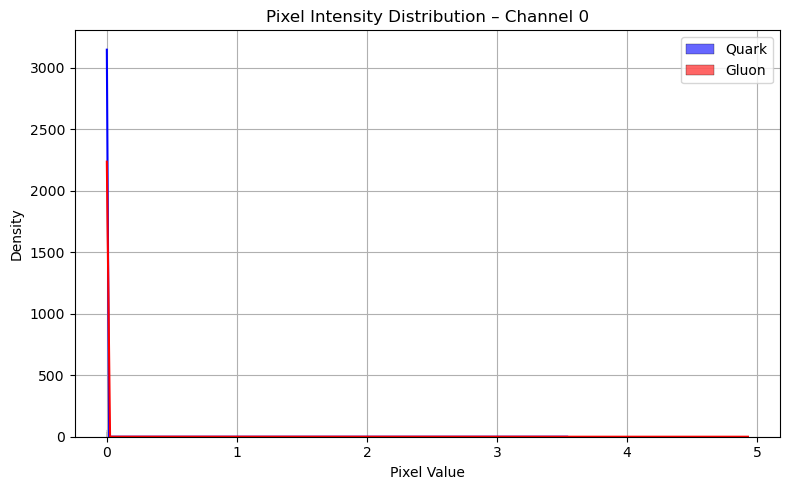

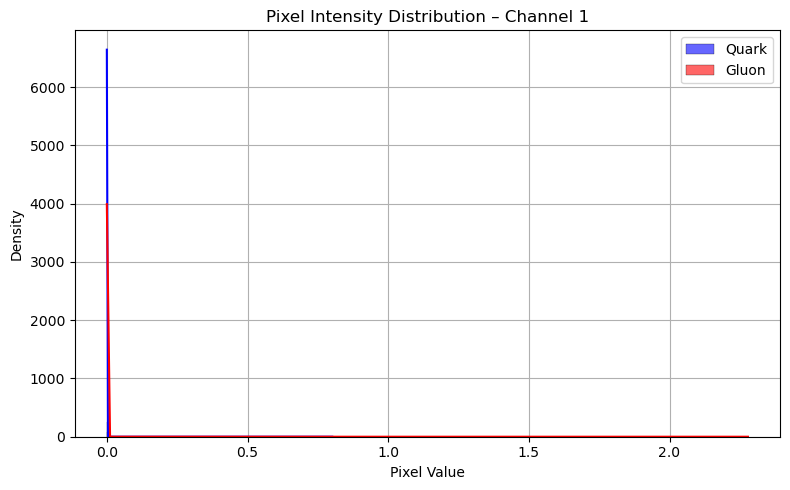

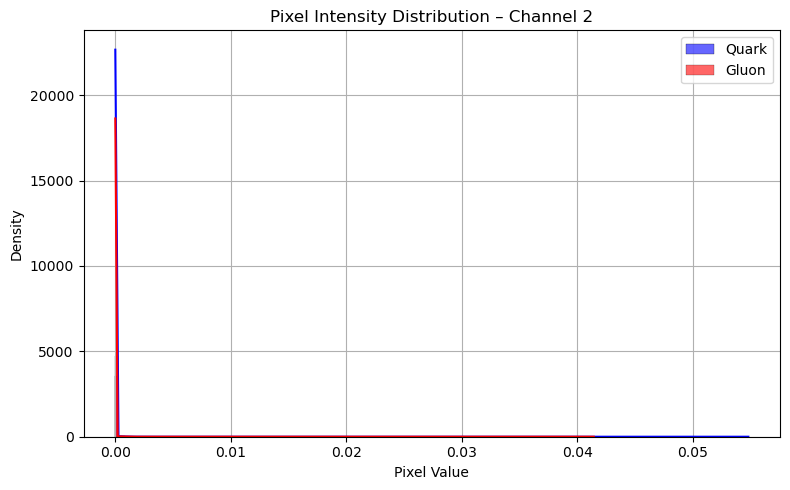

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = r"C:\Users\riakh\Downloads\quark-gluon_train-set_n793900-001.hdf5"
with h5py.File(path, 'r') as f:
    X = f['X_jets'][:1000] 
    y = f['y'][:1000]

quark_imgs = X[y == 0]
gluon_imgs = X[y == 1]

num_channels = X.shape[-1]
for ch in range(num_channels):
    quark_pixels = quark_imgs[..., ch].ravel()
    gluon_pixels = gluon_imgs[..., ch].ravel()

    plt.figure(figsize=(8, 5))
    sns.histplot(quark_pixels, bins=200, stat='density', label='Quark', color='blue', kde=True, alpha=0.6)
    sns.histplot(gluon_pixels, bins=200, stat='density', label='Gluon', color='red', kde=True, alpha=0.6)
    plt.title(f"Pixel Intensity Distribution – Channel {ch}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


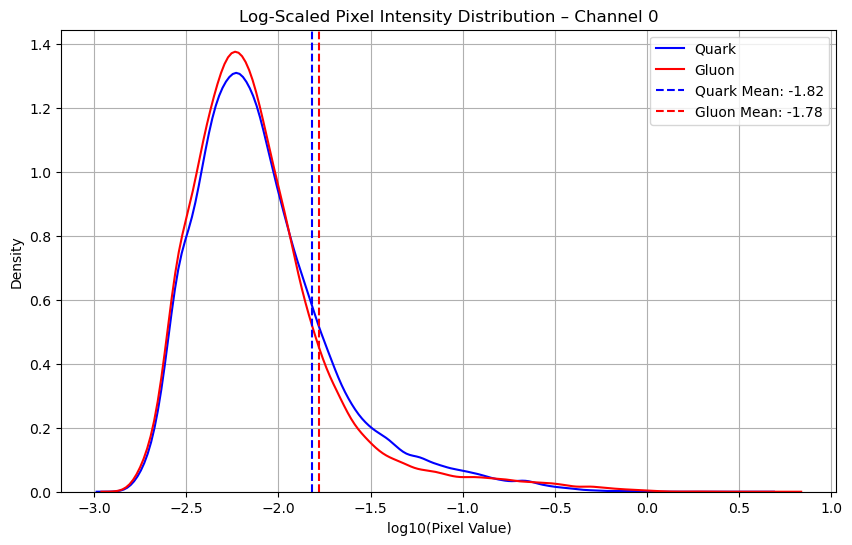

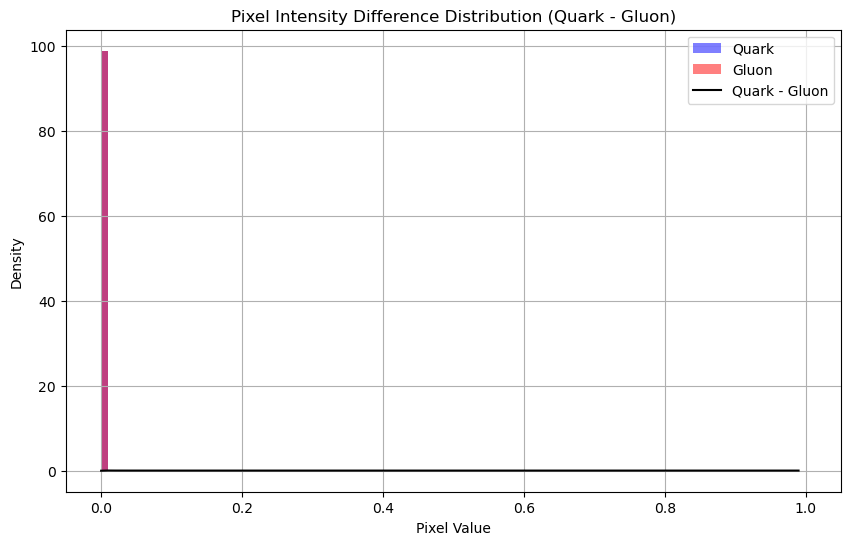

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = r"C:\Users\riakh\Downloads\quark-gluon_train-set_n793900-001.hdf5"
with h5py.File(path, 'r') as f:
    X = f['X_jets'][:5000]  
    y = f['y'][:5000]     

channel = 0
quark_pixels = X[y == 0, :, :, channel].flatten()
gluon_pixels = X[y == 1, :, :, channel].flatten()

quark_pixels_nonzero = quark_pixels[quark_pixels > 0]
gluon_pixels_nonzero = gluon_pixels[gluon_pixels > 0]

plt.figure(figsize=(10, 6))
sns.kdeplot(np.log10(quark_pixels_nonzero), label='Quark', color='blue', linewidth=1.5)
sns.kdeplot(np.log10(gluon_pixels_nonzero), label='Gluon', color='red', linewidth=1.5)

quark_mean_log = np.log10(np.mean(quark_pixels_nonzero))
gluon_mean_log = np.log10(np.mean(gluon_pixels_nonzero))
plt.axvline(quark_mean_log, color='blue', linestyle='--', label=f'Quark Mean: {quark_mean_log:.2f}')
plt.axvline(gluon_mean_log, color='red', linestyle='--', label=f'Gluon Mean: {gluon_mean_log:.2f}')

plt.xlabel('log10(Pixel Value)')
plt.ylabel('Density')
plt.title('Log-Scaled Pixel Intensity Distribution – Channel 0')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 100)
plt.hist(quark_pixels, bins=bins, alpha=0.5, label='Quark', color='blue', density=True)
plt.hist(gluon_pixels, bins=bins, alpha=0.5, label='Gluon', color='red', density=True)
plt.plot(bins[:-1], np.histogram(quark_pixels, bins=bins, density=True)[0] -
         np.histogram(gluon_pixels, bins=bins, density=True)[0], color='black', label='Quark - Gluon')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('Pixel Intensity Difference Distribution (Quark - Gluon)')
plt.legend()
plt.grid(True)
plt.show()


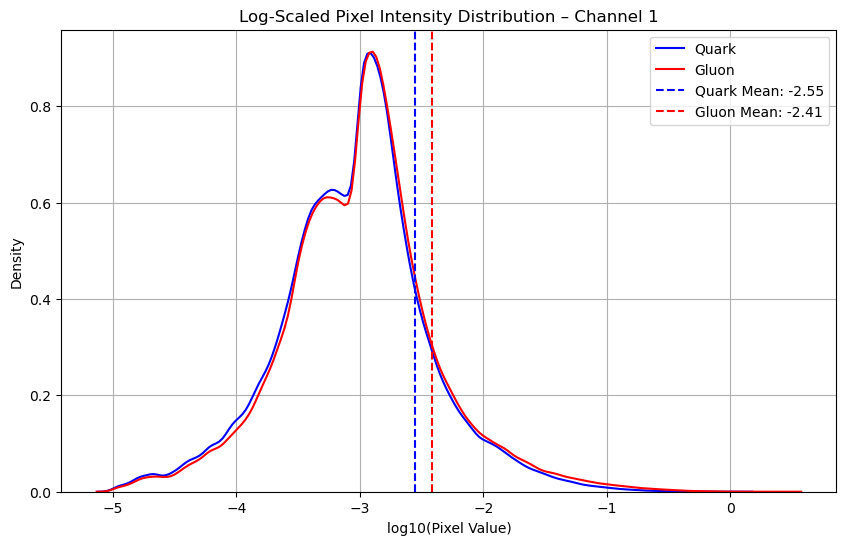

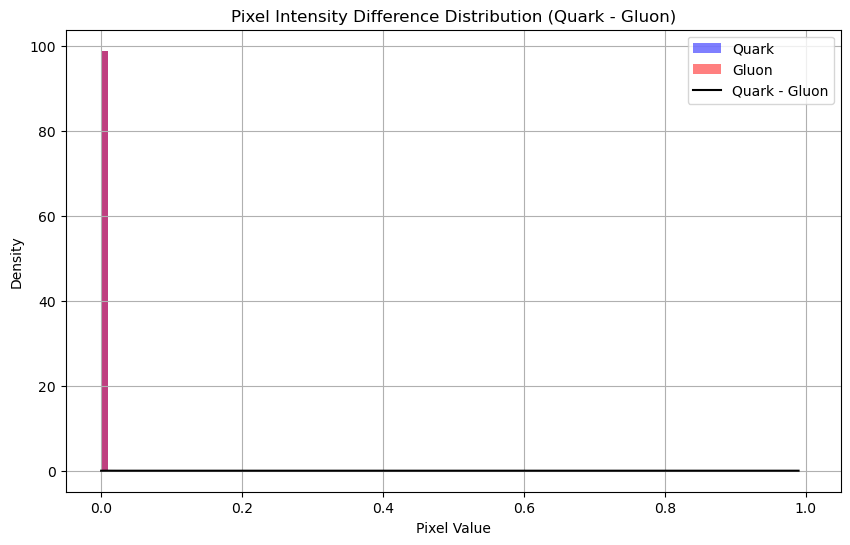

In [23]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = r"C:\Users\riakh\Downloads\quark-gluon_train-set_n793900-001.hdf5"
with h5py.File(path, 'r') as f:
    X = f['X_jets'][:5000] 
    y = f['y'][:5000]     

channel = 1
quark_pixels = X[y == 0, :, :, channel].flatten()
gluon_pixels = X[y == 1, :, :, channel].flatten()

quark_pixels_nonzero = quark_pixels[quark_pixels > 0]
gluon_pixels_nonzero = gluon_pixels[gluon_pixels > 0]

plt.figure(figsize=(10, 6))
sns.kdeplot(np.log10(quark_pixels_nonzero), label='Quark', color='blue', linewidth=1.5)
sns.kdeplot(np.log10(gluon_pixels_nonzero), label='Gluon', color='red', linewidth=1.5)

quark_mean_log = np.log10(np.mean(quark_pixels_nonzero))
gluon_mean_log = np.log10(np.mean(gluon_pixels_nonzero))
plt.axvline(quark_mean_log, color='blue', linestyle='--', label=f'Quark Mean: {quark_mean_log:.2f}')
plt.axvline(gluon_mean_log, color='red', linestyle='--', label=f'Gluon Mean: {gluon_mean_log:.2f}')

plt.xlabel('log10(Pixel Value)')
plt.ylabel('Density')
plt.title('Log-Scaled Pixel Intensity Distribution – Channel 1')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 100)
plt.hist(quark_pixels, bins=bins, alpha=0.5, label='Quark', color='blue', density=True)
plt.hist(gluon_pixels, bins=bins, alpha=0.5, label='Gluon', color='red', density=True)
plt.plot(bins[:-1], np.histogram(quark_pixels, bins=bins, density=True)[0] -
         np.histogram(gluon_pixels, bins=bins, density=True)[0], color='black', label='Quark - Gluon')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('Pixel Intensity Difference Distribution (Quark - Gluon)')
plt.legend()
plt.grid(True)
plt.show()


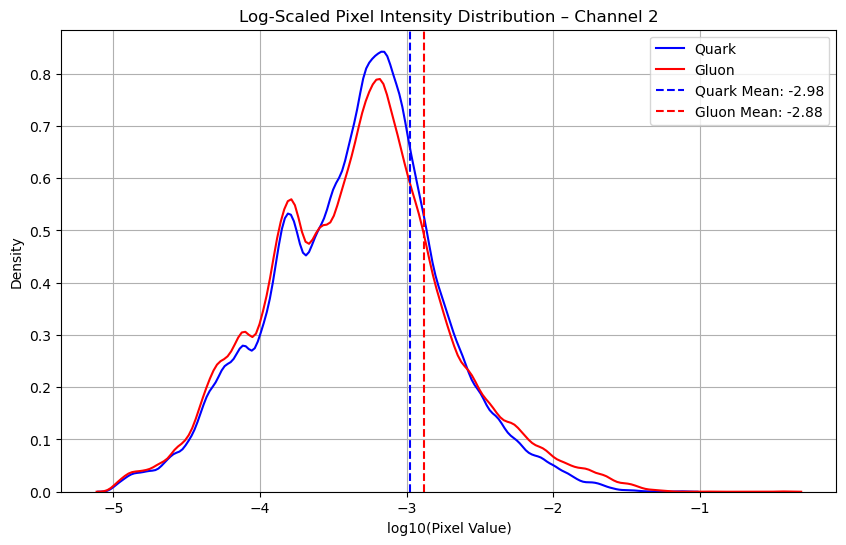

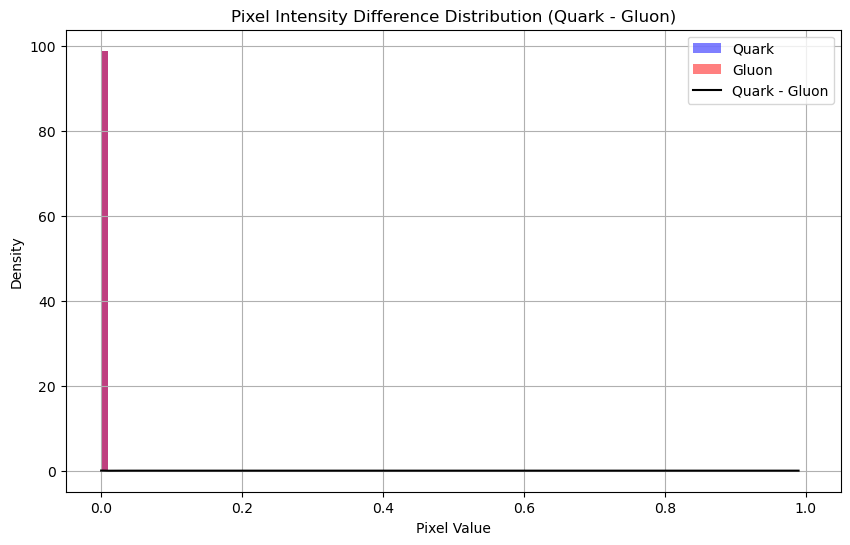

In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = r"C:\Users\riakh\Downloads\quark-gluon_train-set_n793900-001.hdf5"
with h5py.File(path, 'r') as f:
    X = f['X_jets'][:5000] 
    y = f['y'][:5000]    

channel = 2
quark_pixels = X[y == 0, :, :, channel].flatten()
gluon_pixels = X[y == 1, :, :, channel].flatten()

quark_pixels_nonzero = quark_pixels[quark_pixels > 0]
gluon_pixels_nonzero = gluon_pixels[gluon_pixels > 0]

plt.figure(figsize=(10, 6))
sns.kdeplot(np.log10(quark_pixels_nonzero), label='Quark', color='blue', linewidth=1.5)
sns.kdeplot(np.log10(gluon_pixels_nonzero), label='Gluon', color='red', linewidth=1.5)

quark_mean_log = np.log10(np.mean(quark_pixels_nonzero))
gluon_mean_log = np.log10(np.mean(gluon_pixels_nonzero))
plt.axvline(quark_mean_log, color='blue', linestyle='--', label=f'Quark Mean: {quark_mean_log:.2f}')
plt.axvline(gluon_mean_log, color='red', linestyle='--', label=f'Gluon Mean: {gluon_mean_log:.2f}')

plt.xlabel('log10(Pixel Value)')
plt.ylabel('Density')
plt.title('Log-Scaled Pixel Intensity Distribution – Channel 2')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 100)
plt.hist(quark_pixels, bins=bins, alpha=0.5, label='Quark', color='blue', density=True)
plt.hist(gluon_pixels, bins=bins, alpha=0.5, label='Gluon', color='red', density=True)
plt.plot(bins[:-1], np.histogram(quark_pixels, bins=bins, density=True)[0] -
         np.histogram(gluon_pixels, bins=bins, density=True)[0], color='black', label='Quark - Gluon')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('Pixel Intensity Difference Distribution (Quark - Gluon)')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
quark_mean_img = np.mean(X[y == 0], axis=0))
gluon_mean_img = np.mean(X[y == 1], axis=0)

diff_map = quark_mean_img - gluon_mean_img


In [9]:
from scipy.stats import ttest_ind

quark_flat = X[y == 0].reshape(-1, 125 * 125 * 3)
gluon_flat = X[y == 1].reshape(-1, 125 * 125 * 3)

t_vals, p_vals = ttest_ind(quark_flat, gluon_flat, axis=0, equal_var=False)

p_val_map = p_vals.reshape(125, 125, 3)
t_val_map = t_vals.reshape(125, 125, 3)


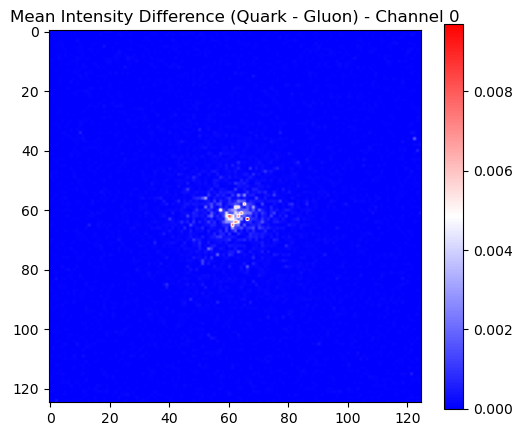

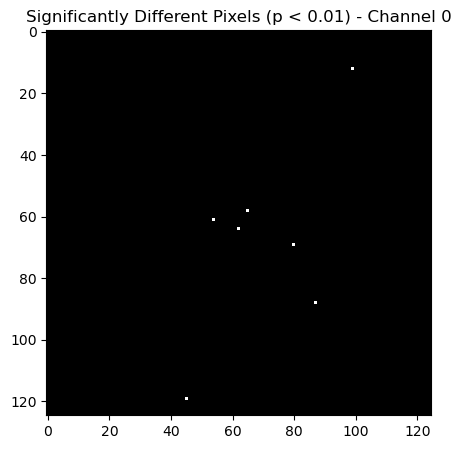

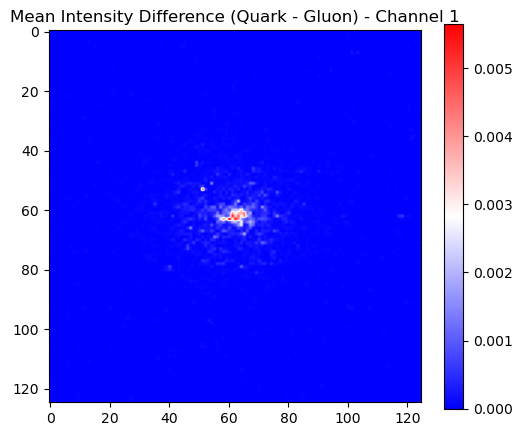

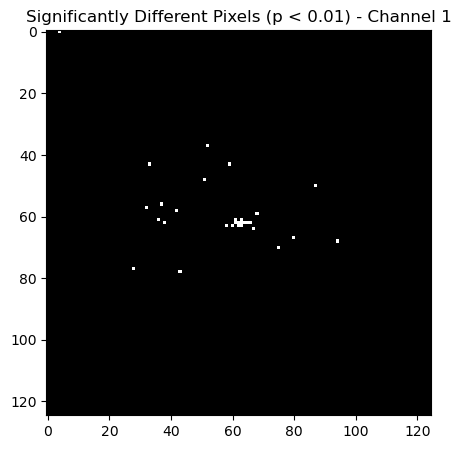

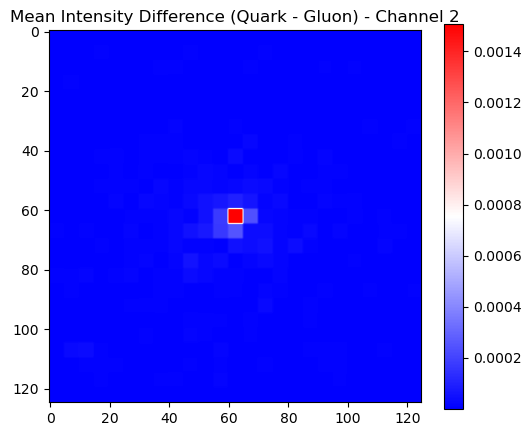

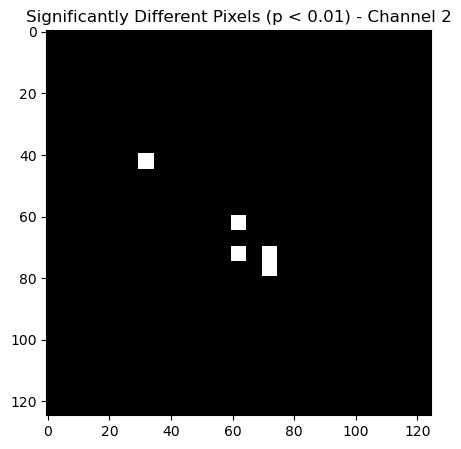

In [10]:
import matplotlib.pyplot as plt

for ch in range(3):
    plt.figure(figsize=(6, 5))
    plt.imshow(np.abs(diff_map[:, :, ch]), cmap='bwr')
    plt.title(f"Mean Intensity Difference (Quark - Gluon) - Channel {ch}")
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.imshow(p_val_map[:, :, ch] < 0.01, cmap='gray')
    plt.title(f"Significantly Different Pixels (p < 0.01) - Channel {ch}")
    plt.show()


In [12]:
import numpy as np

threshold = 0.01

significant_pixels = []

for ch in range(3):
    mask = p_val_map[:, :, ch] < threshold
    coords = np.argwhere(mask)

    for i, j in coords:
        significant_pixels.append((i, j, ch))

print(f"Found {len(significant_pixels)} significantly different pixels (p < {threshold})")
print("Sample pixel locations (i, j, channel):")
print(significant_pixels[:162])  


Found 162 significantly different pixels (p < 0.01)
Sample pixel locations (i, j, channel):
[(12, 99, 0), (58, 65, 0), (61, 54, 0), (64, 62, 0), (69, 80, 0), (88, 87, 0), (119, 45, 0), (0, 4, 1), (37, 52, 1), (43, 33, 1), (43, 59, 1), (48, 51, 1), (50, 87, 1), (56, 37, 1), (57, 32, 1), (58, 42, 1), (59, 68, 1), (61, 36, 1), (61, 61, 1), (61, 63, 1), (62, 38, 1), (62, 61, 1), (62, 62, 1), (62, 63, 1), (62, 64, 1), (62, 65, 1), (62, 66, 1), (63, 58, 1), (63, 60, 1), (63, 62, 1), (63, 63, 1), (64, 67, 1), (67, 80, 1), (68, 94, 1), (70, 75, 1), (77, 28, 1), (78, 43, 1), (40, 30, 2), (40, 31, 2), (40, 32, 2), (40, 33, 2), (40, 34, 2), (41, 30, 2), (41, 31, 2), (41, 32, 2), (41, 33, 2), (41, 34, 2), (42, 30, 2), (42, 31, 2), (42, 32, 2), (42, 33, 2), (42, 34, 2), (43, 30, 2), (43, 31, 2), (43, 32, 2), (43, 33, 2), (43, 34, 2), (44, 30, 2), (44, 31, 2), (44, 32, 2), (44, 33, 2), (44, 34, 2), (60, 60, 2), (60, 61, 2), (60, 62, 2), (60, 63, 2), (60, 64, 2), (61, 60, 2), (61, 61, 2), (61, 62, 2)

In [25]:
import numpy as np

threshold = 0.01
significant_pixel_data = []

quark_imgs = X[y == 0]  
gluon_imgs = X[y == 1]  

for ch in range(3):
    mask = p_val_map[:, :, ch] < threshold
    coords = np.argwhere(mask)

    for i, j in coords:
        quark_vals = quark_imgs[:, i, j, ch]
        gluon_vals = gluon_imgs[:, i, j, ch]
        significant_pixel_data.append({
            "i": i,
            "j": j,
            "channel": ch,
            "quark_values": quark_vals,
            "gluon_values": gluon_vals,
            "quark_mean": np.mean(quark_vals),
            "gluon_mean": np.mean(gluon_vals)
        })


for k in range(min(50, len(significant_pixel_data))):
    entry = significant_pixel_data[k]
    print(f"Pixel ({entry['i']}, {entry['j']}) | Channel {entry['channel']}")
    print(f"Quark mean: {entry['quark_mean']:.4f} | Gluon mean: {entry['gluon_mean']:.4f}")
    print(f"Quark values: {entry['quark_values'][:200]} ...")
    print(f"Gluon values: {entry['gluon_values'][:200]} ...\n")


Pixel (12, 99) | Channel 0
Quark mean: 0.0000 | Gluon mean: 0.0000
Quark values: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00389135 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         

In [21]:
import numpy as np

threshold = 0.0001 

quark_active_mask = (quark_imgs > threshold).astype(int)  
gluon_active_mask = (gluon_imgs > threshold).astype(int)  

quark_counts = np.sum(quark_active_mask, axis=0) 
gluon_counts = np.sum(gluon_active_mask, axis=0)  

diff_counts = quark_counts - gluon_counts  
abs_diff = np.abs(diff_counts)

quark_total = quark_active_mask.shape[0]
gluon_total = gluon_active_mask.shape[0]

quark_pct = quark_counts / quark_total
gluon_pct = gluon_counts / gluon_total
diff_pct = quark_pct - gluon_pct  


In [20]:
flat_diff = np.abs(diff_pct).reshape(-1)
top_n = 200
top_idxs = np.argsort(flat_diff)[-top_n:]

print(f"Top {top_n} pixels with largest activation frequency difference (quark vs gluon):\n")

for idx in top_idxs:
    i, j, ch = np.unravel_index(idx, diff_pct.shape)
    q_pct = quark_pct[i, j, ch]
    g_pct = gluon_pct[i, j, ch]
    diff = diff_pct[i, j, ch]
    
    print(f"Pixel ({i}, {j}) | Channel {ch}")
    print(f"  Quark % active: {q_pct*100:.2f}%")
    print(f"  Gluon % active: {g_pct*100:.2f}%")
    print(f"  Difference: {diff*100:.2f}%\n")


Top 200 pixels with largest activation frequency difference (quark vs gluon):

Pixel (69, 65) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (65, 66) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (66, 65) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (65, 65) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (67, 65) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (69, 68) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (69, 67) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (67, 67) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (67, 68) | Channel 2
  Quark % active: 13.88%
  Gluon % active: 10.93%
  Difference: 2.95%

Pixel (69, 69) | Channel 2
  Quark % ac

In [29]:
print(X_flat.shape)

(5000, 192)


In [31]:
with h5py.File(r"C:\Users\riakh\Downloads\quark-gluon_train-set_n793900-001.hdf5", 'r') as f:
    X = f['X_jets'][:5000]
    y = f['y'][:5000]

X_resized = np.array([resize(img, (32, 32), mode='reflect') for img in X])  
X_flat = X_resized.reshape(5000, -1) 

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, stratify=y, random_state=42
)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [34]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden=128, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = MLP(input_dim=input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test).argmax(dim=1)
        acc = (preds == y_test).float().mean().item()
    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")


Epoch 01 | Loss: 0.6931 | Test Acc: 0.5030
Epoch 02 | Loss: 0.6929 | Test Acc: 0.5040
Epoch 03 | Loss: 0.6924 | Test Acc: 0.6120
Epoch 04 | Loss: 0.6919 | Test Acc: 0.5930
Epoch 05 | Loss: 0.6913 | Test Acc: 0.6030
Epoch 06 | Loss: 0.6903 | Test Acc: 0.5380
Epoch 07 | Loss: 0.6895 | Test Acc: 0.5450
Epoch 08 | Loss: 0.6880 | Test Acc: 0.6050
Epoch 09 | Loss: 0.6865 | Test Acc: 0.6420
Epoch 10 | Loss: 0.6847 | Test Acc: 0.6420
Epoch 11 | Loss: 0.6831 | Test Acc: 0.6280
Epoch 12 | Loss: 0.6814 | Test Acc: 0.6220
Epoch 13 | Loss: 0.6793 | Test Acc: 0.6290
Epoch 14 | Loss: 0.6765 | Test Acc: 0.6360
Epoch 15 | Loss: 0.6743 | Test Acc: 0.6310
Epoch 16 | Loss: 0.6718 | Test Acc: 0.6360
Epoch 17 | Loss: 0.6686 | Test Acc: 0.6320
Epoch 18 | Loss: 0.6663 | Test Acc: 0.6300
Epoch 19 | Loss: 0.6629 | Test Acc: 0.6330
Epoch 20 | Loss: 0.6603 | Test Acc: 0.6330
Epoch 21 | Loss: 0.6577 | Test Acc: 0.6320
Epoch 22 | Loss: 0.6537 | Test Acc: 0.6330
Epoch 23 | Loss: 0.6499 | Test Acc: 0.6380
Epoch 24 | 

In [37]:
X_resized = np.array([resize(img, (8, 8), mode='reflect') for img in X]) 
X_flat = X_resized.reshape(5000, -1)  

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, stratify=y, random_state=42
)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [38]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden=96, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = MLP(input_dim=input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test).argmax(dim=1)
        acc = (preds == y_test).float().mean().item()
    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")


Epoch 01 | Loss: 0.6933 | Test Acc: 0.4970
Epoch 02 | Loss: 0.6936 | Test Acc: 0.4970
Epoch 03 | Loss: 0.6933 | Test Acc: 0.5030
Epoch 04 | Loss: 0.6933 | Test Acc: 0.5030
Epoch 05 | Loss: 0.6931 | Test Acc: 0.5030
Epoch 06 | Loss: 0.6931 | Test Acc: 0.5030
Epoch 07 | Loss: 0.6933 | Test Acc: 0.5030
Epoch 08 | Loss: 0.6930 | Test Acc: 0.5040
Epoch 09 | Loss: 0.6929 | Test Acc: 0.4980
Epoch 10 | Loss: 0.6931 | Test Acc: 0.4980
Epoch 11 | Loss: 0.6932 | Test Acc: 0.4980
Epoch 12 | Loss: 0.6932 | Test Acc: 0.5040
Epoch 13 | Loss: 0.6930 | Test Acc: 0.5030
Epoch 14 | Loss: 0.6929 | Test Acc: 0.5030
Epoch 15 | Loss: 0.6929 | Test Acc: 0.5030
Epoch 16 | Loss: 0.6933 | Test Acc: 0.5030
Epoch 17 | Loss: 0.6929 | Test Acc: 0.5030
Epoch 18 | Loss: 0.6929 | Test Acc: 0.5030
Epoch 19 | Loss: 0.6931 | Test Acc: 0.6100
Epoch 20 | Loss: 0.6930 | Test Acc: 0.4980
Epoch 21 | Loss: 0.6930 | Test Acc: 0.4980
Epoch 22 | Loss: 0.6930 | Test Acc: 0.5580
Epoch 23 | Loss: 0.6929 | Test Acc: 0.5020
Epoch 24 | 

In [42]:
from scipy.stats import ttest_ind
import numpy as np

X_flat = X.reshape(X.shape[0], -1) 

quark_flat = X_flat[y == 0]
gluon_flat = X_flat[y == 1]
t_vals, p_vals = ttest_ind(quark_flat, gluon_flat, axis=0, equal_var=False)

top_indices = np.argsort(p_vals)[:192] 

X_selected = X_flat[:, top_indices]  


X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)



import torch.nn as nn
import torch.optim as optim

class MLPSelective(nn.Module):
    def __init__(self, input_dim=192, hidden=64, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.model(x)

model = MLPSelective()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(X_test).argmax(dim=1)
        acc = (pred == y_test).float().mean().item()
    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")


Epoch 01 | Loss: 0.6930 | Test Acc: 0.5050
Epoch 02 | Loss: 0.6925 | Test Acc: 0.5100
Epoch 03 | Loss: 0.6913 | Test Acc: 0.6200
Epoch 04 | Loss: 0.6902 | Test Acc: 0.6150
Epoch 05 | Loss: 0.6887 | Test Acc: 0.6350
Epoch 06 | Loss: 0.6873 | Test Acc: 0.6300
Epoch 07 | Loss: 0.6854 | Test Acc: 0.6250
Epoch 08 | Loss: 0.6835 | Test Acc: 0.6250
Epoch 09 | Loss: 0.6808 | Test Acc: 0.6350
Epoch 10 | Loss: 0.6781 | Test Acc: 0.6350
Epoch 11 | Loss: 0.6737 | Test Acc: 0.6350
Epoch 12 | Loss: 0.6719 | Test Acc: 0.6350
Epoch 13 | Loss: 0.6685 | Test Acc: 0.6400
Epoch 14 | Loss: 0.6682 | Test Acc: 0.6350
Epoch 15 | Loss: 0.6647 | Test Acc: 0.6350
Epoch 16 | Loss: 0.6607 | Test Acc: 0.6400
Epoch 17 | Loss: 0.6601 | Test Acc: 0.6400
Epoch 18 | Loss: 0.6564 | Test Acc: 0.6450
Epoch 19 | Loss: 0.6544 | Test Acc: 0.6450
Epoch 20 | Loss: 0.6528 | Test Acc: 0.6450
Epoch 21 | Loss: 0.6544 | Test Acc: 0.6500
Epoch 22 | Loss: 0.6503 | Test Acc: 0.6550
Epoch 23 | Loss: 0.6461 | Test Acc: 0.6500
Epoch 24 | 

In [53]:
top_indices = np.argsort(p_vals)[:432] 

X_selected = X_flat[:, top_indices] 


from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train = torch.tensor(X_train, dtype=torch.float32)
print(X_train.shape)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

model = MLPSelective()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(X_test).argmax(dim=1)
        acc = (pred == y_test).float().mean().item()
    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")


torch.Size([800, 432])
Epoch 01 | Loss: 0.6939 | Test Acc: 0.5050
Epoch 02 | Loss: 0.6913 | Test Acc: 0.5050
Epoch 03 | Loss: 0.6894 | Test Acc: 0.5050
Epoch 04 | Loss: 0.6858 | Test Acc: 0.6650
Epoch 05 | Loss: 0.6819 | Test Acc: 0.6450
Epoch 06 | Loss: 0.6771 | Test Acc: 0.6450
Epoch 07 | Loss: 0.6728 | Test Acc: 0.6400
Epoch 08 | Loss: 0.6659 | Test Acc: 0.6250
Epoch 09 | Loss: 0.6614 | Test Acc: 0.6400
Epoch 10 | Loss: 0.6545 | Test Acc: 0.6450
Epoch 11 | Loss: 0.6515 | Test Acc: 0.6450
Epoch 12 | Loss: 0.6471 | Test Acc: 0.6450
Epoch 13 | Loss: 0.6421 | Test Acc: 0.6500
Epoch 14 | Loss: 0.6355 | Test Acc: 0.6650
Epoch 15 | Loss: 0.6319 | Test Acc: 0.6600
Epoch 16 | Loss: 0.6298 | Test Acc: 0.6650
Epoch 17 | Loss: 0.6248 | Test Acc: 0.6650
Epoch 18 | Loss: 0.6187 | Test Acc: 0.6850
Epoch 19 | Loss: 0.6181 | Test Acc: 0.6950
Epoch 20 | Loss: 0.6138 | Test Acc: 0.6850
Epoch 21 | Loss: 0.6121 | Test Acc: 0.6900
Epoch 22 | Loss: 0.6071 | Test Acc: 0.7100
Epoch 23 | Loss: 0.6043 | Test 

In [47]:

class SineKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, device='cpu', grid_size=5, is_first=False, add_bias=True, norm_freq=True):
        super(SineKANLayer, self).__init__()
        self.grid_size = grid_size
        self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_first = is_first
        self.add_bias = add_bias
        self.A, self.K, self.C = 0.9724, 0.9884, 0.9994

        self.grid_norm_factor = (torch.arange(grid_size, dtype=torch.float32) + 1).reshape(1, 1, grid_size)

        if is_first:
            amp = torch.empty(output_dim, input_dim, 1).normal_(0, .4) / output_dim / self.grid_norm_factor
        else:
            amp = torch.empty(output_dim, input_dim, 1).uniform_(-1, 1) / output_dim / self.grid_norm_factor
        self.amplitudes = nn.Parameter(amp.float())

        grid_phase = torch.arange(1, grid_size + 1, dtype=torch.float32).reshape(1, 1, 1, grid_size) / (grid_size + 1)
        self.input_phase = torch.linspace(0, math.pi, input_dim, dtype=torch.float32).reshape(1, 1, input_dim, 1).to(device)
        phase = grid_phase.to(device) + self.input_phase

        if norm_freq:
            self.freq = nn.Parameter((torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size) / (grid_size + 1)**(1 - is_first)).float())
        else:
            self.freq = nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size))

        for i in range(1, self.grid_size):
            phase = self.forward_step(phase, i)

        self.register_buffer('phase', phase.float())

        if self.add_bias:
            self.bias = nn.Parameter(torch.ones(1, output_dim).float() / output_dim)

    def forward_step(self, i_n, i):
        ratio = self.A * (self.grid_size ** (-self.K)) + self.C
        return ratio * i_n

    def forward(self, x):
        x = x.to(self.amplitudes.dtype)
        x = x.view(x.shape[0], -1)
        x_reshaped = x.view(x.shape[0], 1, x.shape[1], 1)
        s = torch.sin(x_reshaped * self.freq + self.phase)
        y = torch.einsum('bijd,ojd->bo', s, self.amplitudes)
        if self.add_bias:
            y = y + self.bias
        return y

class SineKAN(nn.Module):
    def __init__(self, input_dim, hidden=64, output_dim=2):
        super().__init__()
        self.l1 = SineKANLayer(input_dim, hidden, is_first=True)
        self.l2 = SineKANLayer(hidden, output_dim)

    def forward(self, x):
        return self.l2(self.l1(x))


model = SineKAN(input_dim=192, hidden=64, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
best_model_path = "best_sinekan_model.pt"

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(X_test).argmax(dim=1)
        acc = (pred == y_test).float().mean().item()

        # Save best model
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f} | Best Acc: {best_acc:.4f}")

print(f"\nBest model saved to '{best_model_path}' with accuracy {best_acc:.4f}")


Epoch 01 | Loss: 2.0974 | Test Acc: 0.4950 | Best Acc: 0.4950
Epoch 02 | Loss: 3.9584 | Test Acc: 0.4950 | Best Acc: 0.4950
Epoch 03 | Loss: 3.1640 | Test Acc: 0.4950 | Best Acc: 0.4950
Epoch 04 | Loss: 1.0954 | Test Acc: 0.5050 | Best Acc: 0.5050
Epoch 05 | Loss: 0.8931 | Test Acc: 0.4950 | Best Acc: 0.5050
Epoch 06 | Loss: 0.6986 | Test Acc: 0.4950 | Best Acc: 0.5050
Epoch 07 | Loss: 0.6974 | Test Acc: 0.4950 | Best Acc: 0.5050
Epoch 08 | Loss: 0.7493 | Test Acc: 0.5300 | Best Acc: 0.5300
Epoch 09 | Loss: 0.6834 | Test Acc: 0.4950 | Best Acc: 0.5300
Epoch 10 | Loss: 1.1966 | Test Acc: 0.5050 | Best Acc: 0.5300
Epoch 11 | Loss: 2.7173 | Test Acc: 0.4950 | Best Acc: 0.5300
Epoch 12 | Loss: 1.5557 | Test Acc: 0.5050 | Best Acc: 0.5300
Epoch 13 | Loss: 0.7146 | Test Acc: 0.5050 | Best Acc: 0.5300
Epoch 14 | Loss: 0.8328 | Test Acc: 0.4950 | Best Acc: 0.5300
Epoch 15 | Loss: 0.9912 | Test Acc: 0.5050 | Best Acc: 0.5300
Epoch 16 | Loss: 0.6972 | Test Acc: 0.5050 | Best Acc: 0.5300
Epoch 17

In [70]:
top_indices = np.argsort(p_vals)[:432] 

X_selected = X_flat[:, top_indices]  


from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train = torch.tensor(X_train, dtype=torch.float32)
print(X_train.shape)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

torch.Size([800, 432])


In [50]:
import sys
print(sys.version)


3.8.17 (default, Jul  5 2023, 20:35:33) [MSC v.1916 64 bit (AMD64)]


In [20]:
from scipy.stats import ttest_ind
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim


# Load from Drive
file_path = "C:\\Users\\riakh\\Downloads\\quark-gluon_train-set_n793900-001.hdf5"
with h5py.File(file_path, 'r') as f:
    X = f['X_jets'][:1000]
    y = f['y'][:1000]

# Flatten across pixels
X_flat = X.reshape(X.shape[0], -1)

# Compute t-test across classes
quark_flat = X_flat[y == 0]
gluon_flat = X_flat[y == 1]
t_vals, p_vals = ttest_ind(quark_flat, gluon_flat, axis=0, equal_var=False)

# Get top 192 features (e.g., 8x8x3)
top_indices = np.argsort(p_vals)[:192]
X_selected = X_flat[:, top_indices]

print(X_selected.shape)  # should be (1000, 192)


(1000, 192)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

class QSVTLayerMulti(nn.Module):
    def __init__(self, coeff_list):
        super().__init__()
        self.coeff_list = nn.ParameterList([
            nn.Parameter(torch.tensor(coeff, dtype=torch.float32), requires_grad=True)
            for coeff in coeff_list
        ])
        self.theta = nn.Parameter(torch.randn(1))
        self.dev = qml.device("default.qubit", wires=1)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit(x_scalar, theta_val, coeffs_val):
            x_scalar = torch.clamp(x_scalar, -1.0, 1.0)
            qml.RY(x_scalar, wires=0)
            A = x_scalar.detach().cpu().numpy().reshape(1, 1)
            coeffs_np = coeffs_val.detach().cpu().numpy()
            qml.qsvt(A, coeffs_np, encoding_wires=[0], block_encoding="embedding")
            qml.RZ(theta_val[0], wires=0)
            return qml.expval(qml.PauliZ(0))

        self.circuit = circuit

    def forward(self, x):
        B, D = x.shape
        poly_outputs = []
        for coeffs in self.coeff_list:
            outputs = []
            for i in range(D):
                out_i = [self.circuit(x[b, i], self.theta, coeffs) for b in range(B)]
                outputs.append(torch.stack(out_i))
            poly_outputs.append(torch.stack(outputs, dim=1))  # [B, D]
        return torch.stack(poly_outputs, dim=2)  # [B, D, P]

def quantum_lcu_block(qsvt_vals, weight_vals):
    import pennylane as qml
    P = len(qsvt_vals)
    n_ctrl = math.ceil(math.log2(P))
    wires = list(range(n_ctrl + 1))  # control + 1 target
    dev = qml.device("default.qubit", wires=len(wires))

    alpha = torch.sqrt(torch.abs(weight_vals) + 1e-8)
    alpha = alpha / torch.norm(alpha + 1e-8)

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def circuit():
        qml.StatePrep(alpha, wires=wires[:-1])
        for i in range(P):
            ctrl_bin = [int(b) for b in f"{i:0{n_ctrl}b}"]
            qml.ctrl(qml.RY, control=wires[:-1], control_values=ctrl_bin)(2 * qsvt_vals[i], wires=wires[-1])
        qml.adjoint(qml.StatePrep(alpha, wires=wires[:-1]))
        return qml.expval(qml.PauliZ(wires[-1]))

    return circuit()

class QuantumSumBlock(nn.Module):
    def __init__(self, num_polynomials):
        super().__init__()
        self.num_polynomials = num_polynomials
        self.weights = nn.Parameter(torch.randn(num_polynomials))

        self.num_index_qubits = math.ceil(math.log2(num_polynomials))
        self.total_wires = self.num_index_qubits + 2
        self.wires = list(range(self.total_wires))

        self.dev = qml.device("default.qubit", wires=self.total_wires)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit(phi_vals, wts):
            index_wires = self.wires[:self.num_index_qubits]
            hadamard_wire = self.wires[self.num_index_qubits]
            target_wire = self.wires[-1]

            for i in index_wires:
                qml.Hadamard(wires=i)
            qml.Hadamard(wires=hadamard_wire)

            for p in range(self.num_polynomials):
                ctrl_bin = [int(b) for b in f"{p:0{self.num_index_qubits}b}"]
                ctrl_values = [1] + ctrl_bin
                qml.ctrl(qml.RZ, control=[hadamard_wire] + index_wires, control_values=ctrl_values)(
                    2 * wts[p] * phi_vals[p], wires=target_wire
                )

            qml.Hadamard(wires=hadamard_wire)
            return qml.expval(qml.PauliZ(hadamard_wire))

        self.circuit = circuit

    def forward(self, phi_vals):
        return self.circuit(phi_vals, self.weights)

class SineKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, device='cpu', grid_size=5, is_first=False, add_bias=True, norm_freq=True):
        super().__init__()
        self.grid_size = grid_size
        self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_first = is_first
        self.add_bias = add_bias
        self.A, self.K, self.C = 0.9724, 0.9884, 0.9994

        self.grid_norm_factor = (torch.arange(grid_size, dtype=torch.float32) + 1).reshape(1, 1, grid_size)

        if is_first:
            amp = torch.empty(output_dim, input_dim, 1).normal_(0, .4) / output_dim / self.grid_norm_factor
        else:
            amp = torch.empty(output_dim, input_dim, 1).uniform_(-1, 1) / output_dim / self.grid_norm_factor
        self.amplitudes = nn.Parameter(amp.float())

        grid_phase = torch.arange(1, grid_size + 1, dtype=torch.float32).reshape(1, 1, 1, grid_size) / (grid_size + 1)
        self.input_phase = torch.linspace(0, math.pi, input_dim, dtype=torch.float32).reshape(1, 1, input_dim, 1).to(device)
        phase = grid_phase.to(device) + self.input_phase

        if norm_freq:
            self.freq = nn.Parameter((torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size) / (grid_size + 1)**(1 - is_first)).float())
        else:
            self.freq = nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size))

        for i in range(1, self.grid_size):
            phase = self.forward_step(phase, i)

        self.register_buffer('phase', phase.float())

        if self.add_bias:
            self.bias = nn.Parameter(torch.ones(1, output_dim).float() / output_dim)

    def forward_step(self, i_n, i):
        ratio = self.A * (self.grid_size ** (-self.K)) + self.C
        return ratio * i_n

    def forward(self, x):
        x = x.to(self.amplitudes.dtype)
        x = x.view(x.shape[0], -1)
        x_reshaped = x.view(x.shape[0], 1, x.shape[1], 1)
        s = torch.sin(x_reshaped * self.freq + self.phase)
        y = torch.einsum('bijd,ojd->bo', s, self.amplitudes)
        if self.add_bias:
            y = y + self.bias
        return y

class SineKAN(nn.Module):
    def __init__(self, input_dim, hidden=64, output_dim=2):
        super().__init__()
        self.l1 = SineKANLayer(input_dim, hidden, is_first=True)
        self.l2 = SineKANLayer(hidden, output_dim)

    def forward(self, x):
        return self.l2(self.l1(x))

class QSVT_LCU_Sum_SineKAN_Model(nn.Module):
    def __init__(self, coeff_list, input_dim=192):
        super().__init__()
        self.qsvt = QSVTLayerMulti(coeff_list)
        self.lcu_weights = nn.Parameter(torch.randn(len(coeff_list)))
        self.sum_block = QuantumSumBlock(num_polynomials=input_dim)
        self.kan = SineKAN(input_dim=1, hidden=64, output_dim=2)

    def forward(self, x):
        qsvt_out = self.qsvt(x) 
        batch_size, D, P = qsvt_out.shape
        out = []
        for b in range(batch_size):
            per_feature_vals = []
            for d in range(D):
                lcu_out = quantum_lcu_block(qsvt_out[b, d, :], self.lcu_weights)
                per_feature_vals.append(lcu_out)
            summed = self.sum_block(torch.stack(per_feature_vals))
            out.append(summed)
        final_input = torch.stack(out).unsqueeze(1)  
        return self.kan(final_input)


coeff_list = [
        [0.0, 1.0, 0.0, -0.5],      
        [0.0, 0.8, 0.0, 0.3]         
    ]
model = QSVT_LCU_Sum_SineKAN_Model(coeff_list, input_dim=192)

optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(X_test).argmax(dim=1)
        acc = (pred == y_test).float().mean().item()
        if acc > best_acc:
            best_acc = acc
        print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f} | Best Acc: {best_acc:.4f}")


Jet Mass Dataset

In [ ]:
with h5py.File("C:\\Users\\riakh\\Downloads\\jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5", 'r') as f:
    X = f['image'][:2000]
    y = f['signal'][:2000]

start = (25 - 10) // 2
X = X[:, start:start+10, start:start+10].reshape(2000, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

class QSVTLayerMultiPoly(nn.Module):
    def __init__(self, coeff_list):
        super().__init__()
        self.coeff_list = nn.ParameterList([
            nn.Parameter(torch.tensor(coeff, dtype=torch.float32), requires_grad=True)
            for coeff in coeff_list
        ])
        self.theta = nn.Parameter(torch.randn(1))
        self.dev = qml.device("default.qubit", wires=1)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit(x_scalar, coeffs, theta):
            x_scalar = torch.clamp(x_scalar, -1.0, 1.0)
            qml.RY(x_scalar, wires=0)
            A = x_scalar.detach().cpu().numpy().reshape(1, 1)
            qml.qsvt(A, coeffs.detach().cpu().numpy(), encoding_wires=[0], block_encoding="embedding")
            qml.RZ(theta[0], wires=0)
            return qml.expval(qml.PauliZ(0))

        self.circuit = circuit

    def forward(self, x):
        B, D = x.shape
        outputs = []
        for coeff in self.coeff_list:
            out = torch.stack([
                torch.stack([self.circuit(x[b, i], coeff, self.theta) for i in range(D)])
                for b in range(B)
            ])
            outputs.append(out)
        return torch.stack(outputs, dim=-1)  # [B, D, P]

class QuantumLCULayer(nn.Module):
    def __init__(self, num_polynomials):
        super().__init__()
        self.num_polynomials = num_polynomials
        self.weights = nn.Parameter(torch.randn(num_polynomials))
        self.n_ctrl = math.ceil(math.log2(num_polynomials))
        self.wires = list(range(self.n_ctrl + 1))
        self.dev = qml.device("default.qubit", wires=len(self.wires))

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit(qsvt_vals, weight_vals):
            alpha = torch.sqrt(torch.abs(weight_vals) + 1e-8)
            alpha = alpha / torch.norm(alpha + 1e-8)
            qml.StatePrep(alpha, wires=self.wires[:-1])
            for i in range(self.num_polynomials):
                ctrl_bin = [int(b) for b in f"{i:0{self.n_ctrl}b}"]
                qml.ctrl(qml.RY, control=self.wires[:-1], control_values=ctrl_bin)(2 * qsvt_vals[i], wires=self.wires[-1])
            qml.adjoint(qml.StatePrep(alpha, wires=self.wires[:-1]))
            return qml.expval(qml.PauliZ(self.wires[-1]))

        self.circuit = circuit

    def forward(self, qsvt_out):  # [B, D, P]
        B, D, P = qsvt_out.shape
        assert P == self.num_polynomials
        return torch.stack([
            torch.stack([self.circuit(qsvt_out[b, d, :], self.weights) for d in range(D)])
            for b in range(B)
        ])  # [B, D]

class QuantumSummationLayer(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        self.dev = qml.device("default.qubit", wires=2)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit(val1, val2):
            qml.RY(val1, wires=0)
            qml.RY(val2, wires=1)
            qml.CNOT(wires=[0, 1])
            return qml.expval(qml.PauliZ(1))

        self.circuit = circuit

    def forward(self, x):  # [B, D]
        B, D = x.shape
        while D > 1:
            new_x = []
            for b in range(B):
                reduced = []
                for i in range(0, D - 1, 2):
                    reduced.append(self.circuit(x[b, i], x[b, i + 1]))
                if D % 2 == 1:
                    reduced.append(x[b, -1])
                new_x.append(torch.stack(reduced))
            x = torch.stack(new_x)
            D = x.shape[1]
        return x.view(B, 1)  # [B, 1]

class SineKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, grid_size=5, is_first=False, add_bias=True):
        super().__init__()
        self.freq = nn.Parameter(torch.arange(1, grid_size + 1).view(1, 1, 1, grid_size).float())
        self.amplitudes = nn.Parameter(
            torch.randn(output_dim, input_dim, grid_size) * 0.1 if is_first else
            torch.empty(output_dim, input_dim, grid_size).uniform_(-0.5, 0.5)
        )
        self.phase = nn.Parameter(torch.linspace(0, math.pi, input_dim).view(1, 1, input_dim, 1))
        self.bias = nn.Parameter(torch.zeros(1, output_dim)) if add_bias else None

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1], 1)
        s = torch.sin(x * self.freq + self.phase)
        y = torch.einsum("bijd,ojd->bo", s, self.amplitudes)
        return y + self.bias if self.bias is not None else y

class QSVT_SineKAN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, coeff_list):
        super().__init__()
        self.qsvt = QSVTLayerMultiPoly(coeff_list)
        self.lcu = QuantumLCULayer(num_polynomials=len(coeff_list))
        self.qsum = QuantumSummationLayer(feature_dim=input_dim)
        self.kan = nn.Sequential(
            SineKANLayer(1, hidden_dim, is_first=True),
            SineKANLayer(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.qsvt(x)   # [B, D, P]
        x = self.lcu(x)    # [B, D]
        x = self.qsum(x)   # [B, 1]
        return self.kan(x) # [B, 2]


coeff_list = [
        [0.0, 1.0, 0.0, -0.5],      
        [0.0, 0.8, 0.0, 0.3]         
    ]

model = QSVT_SineKAN_Model(input_dim=100, hidden_dim=50, output_dim=2, coeff_list=coeff_list)
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        acc = (model(X_test).argmax(1) == y_test).float().mean().item()
        best_acc = max(best_acc, acc)
    print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f} | Best Acc: {best_acc:.4f}")


Epoch 001 | Loss: 1.5813 | Test Acc: 0.6300
Epoch 002 | Loss: 1.6840 | Test Acc: 0.5367
Epoch 003 | Loss: 2.0517 | Test Acc: 0.5333
Epoch 004 | Loss: 1.8974 | Test Acc: 0.5000
Epoch 005 | Loss: 1.9926 | Test Acc: 0.5317
Epoch 006 | Loss: 1.7608 | Test Acc: 0.5700
Epoch 007 | Loss: 1.5624 | Test Acc: 0.5600
Epoch 008 | Loss: 1.7504 | Test Acc: 0.6117
Epoch 009 | Loss: 1.5105 | Test Acc: 0.5983
Epoch 010 | Loss: 1.3889 | Test Acc: 0.6033
Epoch 011 | Loss: 1.2181 | Test Acc: 0.6500
Epoch 012 | Loss: 1.1466 | Test Acc: 0.6567
Epoch 013 | Loss: 1.0277 | Test Acc: 0.6517
Epoch 014 | Loss: 1.0218 | Test Acc: 0.6900
Epoch 015 | Loss: 0.8928 | Test Acc: 0.7283
Epoch 016 | Loss: 0.8352 | Test Acc: 0.7367
Epoch 017 | Loss: 0.7740 | Test Acc: 0.7567
Epoch 018 | Loss: 0.8329 | Test Acc: 0.7633
Epoch 019 | Loss: 0.7692 | Test Acc: 0.7867
Epoch 020 | Loss: 0.7374 | Test Acc: 0.8000
Epoch 021 | Loss: 0.7243 | Test Acc: 0.8150
Epoch 022 | Loss: 0.7299 | Test Acc: 0.8083
